# 전처리


In [16]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)


file_path =  "/content/gdrive/My Drive/EuronData/"

Mounted at /content/gdrive/


In [4]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 24.2 MB/s eta 0:00:00


In [5]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [6]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

### 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [7]:
### 라이브러리
import pickle
import re
import urllib.request
import random
import torch
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from tqdm import tqdm

In [8]:
### 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split


### 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss

In [10]:
### 시드 고정
random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
torch.cuda.manual_seed_all(2024)
torch.backends.cudnn.deterministic = True

In [11]:
### 데이터
#%cd '/content/drive/MyDrive/EuronData'
train = pd.read_csv(file_path + 'review_train.csv', encoding='utf-8')
test = pd.read_csv(file_path + 'review_test.csv', encoding='utf-8')
print(train.shape, test.shape)

(2026, 2) (400, 2)


In [12]:
### label encoding
from sklearn.preprocessing import LabelEncoder
n = train.shape[0]
y = pd.concat([train,test])

le = LabelEncoder()
y['keyword2'] = le.fit_transform(y['keyword2'])
train = y[:n]
test = y[n:]

### NLP

In [13]:
### okt
from konlpy.tag import Okt
okt = Okt()
train['okt'] = train['reviews'].apply(okt.morphs)
test['okt'] = test['reviews'].apply(okt.morphs)

In [17]:
### 불용어 제거
with open(file_path + 'new_stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.readlines()
stop_words = [word.strip() for word in stop_words]


def remove_stopwords(review):
    return [word for word in review if word not in stop_words]


train['okt'] = [remove_stopwords(review) for review in train['okt']]
test['okt'] = [remove_stopwords(review) for review in test['okt']]

In [18]:
### TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_okt = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2,
                            max_df=0.95, stop_words=stop_words)
tfidf_okt_matrix = tfidf_okt.fit_transform(train['reviews'])
tfidf_okt_matrix_test = tfidf_okt.transform(test['reviews'])

vocab_size = tfidf_okt_matrix.shape[1]

In [19]:
### X/y split
X = tfidf_okt_matrix
y = train['keyword2']
X_test = tfidf_okt_matrix_test
y_test = test['keyword2']

### train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=2024
)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1620, 92075) (406, 92075) (400, 92075)
(1620,) (406,) (400,)


### Modeling

In [20]:
### loss function
import torch
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

# 리뷰 예측 함수

In [21]:
#ML 리뷰 예측 함수
def predict_review_ml(model, review, tfidf_vectorizer, label_encoder):
  # 입력된 리뷰를 TF-IDF로 변환
  review_tfidf = tfidf_vectorizer.transform([review])
  # 결과값 내기
  predicted_label = model.predict(review_tfidf)
  # 인코딩된 라벨을 원래의 라벨로 디코딩
  decoded_label = label_encoder.inverse_transform([predicted_label.item()])[0]

  return decoded_label

In [22]:
#DL 리뷰 예측 함수
def predict_review_dl(model, review, tfidf_vectorizer, okt, device, label_encoder):
    model.eval()
    with torch.no_grad():
        # 입력된 리뷰를 TF-IDF로 변환
        review_tfidf = tfidf_vectorizer.transform([review])
        review_tensor = torch.tensor(review_tfidf.toarray(), dtype=torch.float32).to(device)

        # LSTM이 3D 텐서를 기대하므로, 텐서의 차원을 확장해 줍니다.
        review_tensor = review_tensor.unsqueeze(0)  # (batch_size, seq_len, input_dim) 형태로 변환

        # 모델에 입력하고 예측 수행
        output = model(review_tensor)
        _, predicted_label = torch.max(output, 1)

        # 인코딩된 라벨을 원래의 라벨로 디코딩
        decoded_label = label_encoder.inverse_transform([predicted_label.item()])[0]

        return decoded_label

In [23]:
# pickle 파일에서 모델 불러오기
with open(file_path + 'saved_DT', 'rb') as file:
    dt = pickle.load(file)

with open(file_path + 'xgbc.pkl', 'rb') as file:
    xgbc = pickle.load(file)

with open(file_path + 'lgbc.pkl', 'rb') as file:
    lgbc = pickle.load(file)

with open(file_path + 'svm.pkl', 'rb') as file:
    svm = pickle.load(file)

with open(file_path + 'rf.pkl', 'rb') as file:
    rf = pickle.load(file)

with open(file_path + 'catboost.pkl', 'rb') as file:
    cb = pickle.load(file)

In [24]:
# 캣부스트 로그로스 안구해놔서 구하기
cb_pred = cb.predict(X_valid)
valid_acc = accuracy_score(y_valid, cb_pred)
cb_test_pred = cb.predict(X_test)
test_acc = accuracy_score(y_test, cb_test_pred)
print(f'[CBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[CBC] Test Accuracy = {round(test_acc,4)}')

val_probs = cb.predict_proba(X_valid)
test_probs = cb.predict_proba(X_test)

val_log_loss = log_loss(y_valid, val_probs)
test_log_loss = log_loss(y_test, test_probs)

print(f"[CBC] Validation loss = {round(val_log_loss,4)}")
print(f"[CBC] Test loss = {round(test_log_loss,4)}")

[CBC] Validation Accuracy = 0.8399
[CBC] Test Accuracy = 0.35
[CBC] Validation loss = 0.6955
[CBC] Test loss = 1.7577


## 모델 학습

In [25]:
### 베이스라인 LSTM 모델 구축
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,
                        dropout=0.4, bidirectional=False)
    self.dense = nn.Linear(hidden_dim, hidden_dim)
    #self.dense1 = nn.Linear(hidden_dim, hidden_dim // 2)  # 추가된 Dense layer
    #self.dense2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
    self.relu = nn.ReLU()
    #self.leaky_relu = nn.LeakyReLU()
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    x, _ = self.lstm(x)
    x = x[:, -1, :]
    x = self.dense(x)
    x = self.relu(x)
    x = self.fc(x)
    return x

In [26]:
### 모델 훈련 함수
def train(model, train_loader, criterion, optimizer, device):
  model.train()
  total_loss = 0
  correct = 0

  for X, y in tqdm(train_loader, desc='Training', leave=False):
    X = X.unsqueeze(1)  # (batch_size, seq_length, input_dim)
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == y).sum().item()

  return total_loss / len(train_loader), correct / len(train_loader.dataset)

### 모델 평가 함수
def evaluate(model, test_loader, criterion, device):
  model.eval()
  total_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in test_loader:
      X = X.unsqueeze(1)  # (batch_size, seq_length, input_dim)
      X, y = X.to(device), y.to(device)
      outputs = model(X)
      loss = criterion(outputs, y)
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == y).sum().item()

  return total_loss / len(test_loader), correct / len(test_loader.dataset)

In [27]:
X_tensor = torch.tensor(tfidf_okt_matrix.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# ### cross-validation
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=10, shuffle=True, random_state=2024)
# BATCH_SIZE = 32


In [28]:
# 통합된 데이터셋 생성
X_total = torch.cat((X_tensor, torch.tensor(X_test.toarray(), dtype=torch.float32)))
y_total = torch.cat((y_tensor, torch.tensor(y_test.values, dtype=torch.long)))

### cross-validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=2024)
BATCH_SIZE = 32


In [29]:
### 모델 설정
input_dim = tfidf_okt_matrix.shape[1]
hidden_dim = 64
output_dim = 13
lr = 0.001
epochs = 10
weight_decay = 1e-4
early_stopping_rounds = 3  # validation loss가 개선되지 않으면 n epoch 후 조기 중단
MIN_DELTA = 0
fold_val_loss = []
fold_val_acc = []

best_fold_model = None
best_fold_acc = 0.0

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_tensor)):
  print(f'Fold {fold+1}/{kfold.n_splits}')

  train_dataset = TensorDataset(X_total[train_indices], y_total[train_indices])
  valid_dataset = TensorDataset(X_total[val_indices], y_total[val_indices])

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

  model = LSTMModel(input_dim, hidden_dim, output_dim)
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  best_val_loss = float('inf')
  best_model_state = None
  patience_counter = 0

  for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    print(f"[Training] Epoch {epoch+1}: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    print(f"[Validation] Epoch {epoch+1}: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.4f}")

    # Early stopping 조건 확인
    if valid_loss < best_val_loss - MIN_DELTA:
      best_val_loss = valid_loss
      best_model_state = model.state_dict()
      patience_counter = 0  # 갱신되면 카운터 초기화
    else:
      patience_counter += 1

    if patience_counter >= early_stopping_rounds:
      print(f"Early stopping at epoch {epoch+1}")
      break

  # 모델 상태를 최상의 validation loss를 보였던 상태로 롤백
  if best_model_state:
    model.load_state_dict(best_model_state)

  # 현재 fold에서의 모델 정확도가 최고일 경우 저장
  if valid_acc > best_fold_acc:
    best_fold_acc = valid_acc
    best_fold_model = model.state_dict()

  fold_val_loss.append(best_val_loss)
  fold_val_acc.append(valid_acc)

print(f'Average Validation Loss: {np.mean(fold_val_loss):.4f}')
print(f'Average Validation Accuracy: {np.mean(fold_val_acc):.4f}')


Fold 1/10


[Training] Epoch 1: Loss = 2.5527, Accuracy = 0.0900
[Validation] Epoch 1: Loss = 2.5135, Accuracy = 0.1773


[Training] Epoch 2: Loss = 2.2801, Accuracy = 0.3955
[Validation] Epoch 2: Loss = 1.9151, Accuracy = 0.2808


[Training] Epoch 3: Loss = 1.4243, Accuracy = 0.5442
[Validation] Epoch 3: Loss = 1.0534, Accuracy = 0.6700


[Training] Epoch 4: Loss = 0.7183, Accuracy = 0.8815
[Validation] Epoch 4: Loss = 0.6075, Accuracy = 0.8473


[Training] Epoch 5: Loss = 0.3002, Accuracy = 0.9824
[Validation] Epoch 5: Loss = 0.3769, Accuracy = 0.9163


[Training] Epoch 6: Loss = 0.1161, Accuracy = 1.0000
[Validation] Epoch 6: Loss = 0.2937, Accuracy = 0.9360


[Training] Epoch 7: Loss = 0.0620, Accuracy = 1.0000
[Validation] Epoch 7: Loss = 0.2530, Accuracy = 0.9310


[Training] Epoch 8: Loss = 0.0438, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2333, Accuracy = 0.9458


[Training] Epoch 9: Loss = 0.0349, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2260, Accuracy = 0.9409


[Training] Epoch 10: Loss = 0.0282, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2173, Accuracy = 0.9507
Fold 2/10


[Training] Epoch 1: Loss = 2.5507, Accuracy = 0.1530
[Validation] Epoch 1: Loss = 2.5179, Accuracy = 0.2808


[Training] Epoch 2: Loss = 2.3501, Accuracy = 0.4482
[Validation] Epoch 2: Loss = 2.0284, Accuracy = 0.5665


[Training] Epoch 3: Loss = 1.5211, Accuracy = 0.6621
[Validation] Epoch 3: Loss = 1.0933, Accuracy = 0.6995


[Training] Epoch 4: Loss = 0.7187, Accuracy = 0.8914
[Validation] Epoch 4: Loss = 0.6244, Accuracy = 0.8079


[Training] Epoch 5: Loss = 0.2806, Accuracy = 0.9885
[Validation] Epoch 5: Loss = 0.4119, Accuracy = 0.9212


[Training] Epoch 6: Loss = 0.1181, Accuracy = 0.9989
[Validation] Epoch 6: Loss = 0.3422, Accuracy = 0.9212


[Training] Epoch 7: Loss = 0.0686, Accuracy = 1.0000
[Validation] Epoch 7: Loss = 0.3090, Accuracy = 0.9261


[Training] Epoch 8: Loss = 0.0482, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.3014, Accuracy = 0.9163


[Training] Epoch 9: Loss = 0.0368, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2836, Accuracy = 0.9261


[Training] Epoch 10: Loss = 0.0296, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2814, Accuracy = 0.9310
Fold 3/10


[Training] Epoch 1: Loss = 2.5434, Accuracy = 0.0938
[Validation] Epoch 1: Loss = 2.5186, Accuracy = 0.2020


[Training] Epoch 2: Loss = 2.2739, Accuracy = 0.2885
[Validation] Epoch 2: Loss = 2.0085, Accuracy = 0.2808


[Training] Epoch 3: Loss = 1.4870, Accuracy = 0.5705
[Validation] Epoch 3: Loss = 1.1745, Accuracy = 0.6453


[Training] Epoch 4: Loss = 0.7782, Accuracy = 0.8941
[Validation] Epoch 4: Loss = 0.6714, Accuracy = 0.8473


[Training] Epoch 5: Loss = 0.3075, Accuracy = 0.9841
[Validation] Epoch 5: Loss = 0.4152, Accuracy = 0.9261


[Training] Epoch 6: Loss = 0.1139, Accuracy = 0.9984
[Validation] Epoch 6: Loss = 0.3105, Accuracy = 0.9212


[Training] Epoch 7: Loss = 0.0600, Accuracy = 1.0000
[Validation] Epoch 7: Loss = 0.2726, Accuracy = 0.9360


[Training] Epoch 8: Loss = 0.0434, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2549, Accuracy = 0.9409


[Training] Epoch 9: Loss = 0.0345, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2424, Accuracy = 0.9409


[Training] Epoch 10: Loss = 0.0270, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2246, Accuracy = 0.9409
Fold 4/10


[Training] Epoch 1: Loss = 2.5508, Accuracy = 0.1651
[Validation] Epoch 1: Loss = 2.5229, Accuracy = 0.2512


[Training] Epoch 2: Loss = 2.3267, Accuracy = 0.4043
[Validation] Epoch 2: Loss = 1.9516, Accuracy = 0.5468


[Training] Epoch 3: Loss = 1.4031, Accuracy = 0.6023
[Validation] Epoch 3: Loss = 0.9612, Accuracy = 0.7291


[Training] Epoch 4: Loss = 0.6864, Accuracy = 0.8683
[Validation] Epoch 4: Loss = 0.5764, Accuracy = 0.9113


[Training] Epoch 5: Loss = 0.2849, Accuracy = 0.9940
[Validation] Epoch 5: Loss = 0.3865, Accuracy = 0.9360


[Training] Epoch 6: Loss = 0.1100, Accuracy = 0.9984
[Validation] Epoch 6: Loss = 0.3011, Accuracy = 0.9458


[Training] Epoch 7: Loss = 0.0587, Accuracy = 1.0000
[Validation] Epoch 7: Loss = 0.2643, Accuracy = 0.9507


[Training] Epoch 8: Loss = 0.0421, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2434, Accuracy = 0.9606


[Training] Epoch 9: Loss = 0.0333, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2397, Accuracy = 0.9557


[Training] Epoch 10: Loss = 0.0276, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2285, Accuracy = 0.9557
Fold 5/10


[Training] Epoch 1: Loss = 2.5483, Accuracy = 0.1026
[Validation] Epoch 1: Loss = 2.5431, Accuracy = 0.1626


[Training] Epoch 2: Loss = 2.3601, Accuracy = 0.3955
[Validation] Epoch 2: Loss = 2.1154, Accuracy = 0.4483


[Training] Epoch 3: Loss = 1.4701, Accuracy = 0.6144
[Validation] Epoch 3: Loss = 1.1121, Accuracy = 0.6601


[Training] Epoch 4: Loss = 0.7423, Accuracy = 0.8530
[Validation] Epoch 4: Loss = 0.6765, Accuracy = 0.8325


[Training] Epoch 5: Loss = 0.3358, Accuracy = 0.9940
[Validation] Epoch 5: Loss = 0.4435, Accuracy = 0.9015


[Training] Epoch 6: Loss = 0.1196, Accuracy = 0.9978
[Validation] Epoch 6: Loss = 0.3349, Accuracy = 0.9212


[Training] Epoch 7: Loss = 0.0612, Accuracy = 0.9995
[Validation] Epoch 7: Loss = 0.2979, Accuracy = 0.9212


[Training] Epoch 8: Loss = 0.0428, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2740, Accuracy = 0.9261


[Training] Epoch 9: Loss = 0.0321, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2693, Accuracy = 0.9261


[Training] Epoch 10: Loss = 0.0256, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2510, Accuracy = 0.9310
Fold 6/10


[Training] Epoch 1: Loss = 2.5562, Accuracy = 0.1295
[Validation] Epoch 1: Loss = 2.5315, Accuracy = 0.1675


[Training] Epoch 2: Loss = 2.3935, Accuracy = 0.2342
[Validation] Epoch 2: Loss = 2.1304, Accuracy = 0.2709


[Training] Epoch 3: Loss = 1.6559, Accuracy = 0.5250
[Validation] Epoch 3: Loss = 1.2961, Accuracy = 0.6552


[Training] Epoch 4: Loss = 0.8770, Accuracy = 0.8151
[Validation] Epoch 4: Loss = 0.7780, Accuracy = 0.8227


[Training] Epoch 5: Loss = 0.3769, Accuracy = 0.9627
[Validation] Epoch 5: Loss = 0.4900, Accuracy = 0.8867


[Training] Epoch 6: Loss = 0.1688, Accuracy = 0.9962
[Validation] Epoch 6: Loss = 0.4004, Accuracy = 0.9064


[Training] Epoch 7: Loss = 0.0921, Accuracy = 0.9995
[Validation] Epoch 7: Loss = 0.3580, Accuracy = 0.9015


[Training] Epoch 8: Loss = 0.0620, Accuracy = 0.9995
[Validation] Epoch 8: Loss = 0.3366, Accuracy = 0.8966


[Training] Epoch 9: Loss = 0.0472, Accuracy = 0.9995
[Validation] Epoch 9: Loss = 0.3294, Accuracy = 0.9064


[Training] Epoch 10: Loss = 0.0378, Accuracy = 0.9995
[Validation] Epoch 10: Loss = 0.3180, Accuracy = 0.9212
Fold 7/10


[Training] Epoch 1: Loss = 2.5463, Accuracy = 0.0992
[Validation] Epoch 1: Loss = 2.5118, Accuracy = 0.1782


[Training] Epoch 2: Loss = 2.2334, Accuracy = 0.4271
[Validation] Epoch 2: Loss = 1.8295, Accuracy = 0.4257


[Training] Epoch 3: Loss = 1.2388, Accuracy = 0.6793
[Validation] Epoch 3: Loss = 0.9901, Accuracy = 0.7574


[Training] Epoch 4: Loss = 0.5330, Accuracy = 0.9441
[Validation] Epoch 4: Loss = 0.5700, Accuracy = 0.8317


[Training] Epoch 5: Loss = 0.1966, Accuracy = 0.9962
[Validation] Epoch 5: Loss = 0.3963, Accuracy = 0.8911


[Training] Epoch 6: Loss = 0.0791, Accuracy = 0.9989
[Validation] Epoch 6: Loss = 0.3335, Accuracy = 0.9158


[Training] Epoch 7: Loss = 0.0482, Accuracy = 0.9995
[Validation] Epoch 7: Loss = 0.2990, Accuracy = 0.9208


[Training] Epoch 8: Loss = 0.0354, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2837, Accuracy = 0.9208


[Training] Epoch 9: Loss = 0.0287, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2724, Accuracy = 0.9109


[Training] Epoch 10: Loss = 0.0240, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2660, Accuracy = 0.9109
Fold 8/10


[Training] Epoch 1: Loss = 2.5497, Accuracy = 0.0916
[Validation] Epoch 1: Loss = 2.5079, Accuracy = 0.2129


[Training] Epoch 2: Loss = 2.3048, Accuracy = 0.3580
[Validation] Epoch 2: Loss = 1.9529, Accuracy = 0.3614


[Training] Epoch 3: Loss = 1.5144, Accuracy = 0.5905
[Validation] Epoch 3: Loss = 1.0488, Accuracy = 0.7228


[Training] Epoch 4: Loss = 0.6887, Accuracy = 0.8920
[Validation] Epoch 4: Loss = 0.5207, Accuracy = 0.9257


[Training] Epoch 5: Loss = 0.2359, Accuracy = 0.9956
[Validation] Epoch 5: Loss = 0.3568, Accuracy = 0.9257


[Training] Epoch 6: Loss = 0.0934, Accuracy = 0.9995
[Validation] Epoch 6: Loss = 0.2906, Accuracy = 0.9356


[Training] Epoch 7: Loss = 0.0548, Accuracy = 1.0000
[Validation] Epoch 7: Loss = 0.2778, Accuracy = 0.9356


[Training] Epoch 8: Loss = 0.0408, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2598, Accuracy = 0.9356


[Training] Epoch 9: Loss = 0.0332, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2613, Accuracy = 0.9406


[Training] Epoch 10: Loss = 0.0279, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2658, Accuracy = 0.9406
Fold 9/10


[Training] Epoch 1: Loss = 2.5529, Accuracy = 0.1573
[Validation] Epoch 1: Loss = 2.5208, Accuracy = 0.2376


[Training] Epoch 2: Loss = 2.3219, Accuracy = 0.4035
[Validation] Epoch 2: Loss = 1.9838, Accuracy = 0.5000


[Training] Epoch 3: Loss = 1.3816, Accuracy = 0.6809
[Validation] Epoch 3: Loss = 0.9556, Accuracy = 0.7525


[Training] Epoch 4: Loss = 0.6535, Accuracy = 0.8975
[Validation] Epoch 4: Loss = 0.5597, Accuracy = 0.8317


[Training] Epoch 5: Loss = 0.3065, Accuracy = 0.9951
[Validation] Epoch 5: Loss = 0.3889, Accuracy = 0.9059


[Training] Epoch 6: Loss = 0.1357, Accuracy = 0.9984
[Validation] Epoch 6: Loss = 0.2761, Accuracy = 0.9604


[Training] Epoch 7: Loss = 0.0732, Accuracy = 0.9989
[Validation] Epoch 7: Loss = 0.2390, Accuracy = 0.9455


[Training] Epoch 8: Loss = 0.0497, Accuracy = 0.9995
[Validation] Epoch 8: Loss = 0.2246, Accuracy = 0.9455


[Training] Epoch 9: Loss = 0.0384, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2093, Accuracy = 0.9604


[Training] Epoch 10: Loss = 0.0311, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.1981, Accuracy = 0.9554
Fold 10/10


[Training] Epoch 1: Loss = 2.5471, Accuracy = 0.1568
[Validation] Epoch 1: Loss = 2.5048, Accuracy = 0.2228


[Training] Epoch 2: Loss = 2.3044, Accuracy = 0.3854
[Validation] Epoch 2: Loss = 1.9517, Accuracy = 0.3911


[Training] Epoch 3: Loss = 1.4478, Accuracy = 0.6064
[Validation] Epoch 3: Loss = 1.0630, Accuracy = 0.7426


[Training] Epoch 4: Loss = 0.6814, Accuracy = 0.9479
[Validation] Epoch 4: Loss = 0.5404, Accuracy = 0.9208


[Training] Epoch 5: Loss = 0.1912, Accuracy = 0.9973
[Validation] Epoch 5: Loss = 0.3086, Accuracy = 0.9356


[Training] Epoch 6: Loss = 0.0719, Accuracy = 0.9995
[Validation] Epoch 6: Loss = 0.2592, Accuracy = 0.9406


[Training] Epoch 7: Loss = 0.0482, Accuracy = 0.9995
[Validation] Epoch 7: Loss = 0.2439, Accuracy = 0.9356


[Training] Epoch 8: Loss = 0.0380, Accuracy = 1.0000
[Validation] Epoch 8: Loss = 0.2329, Accuracy = 0.9406


[Training] Epoch 9: Loss = 0.0312, Accuracy = 1.0000
[Validation] Epoch 9: Loss = 0.2282, Accuracy = 0.9356


[Training] Epoch 10: Loss = 0.0263, Accuracy = 1.0000
[Validation] Epoch 10: Loss = 0.2259, Accuracy = 0.9356
Average Validation Loss: 0.2471
Average Validation Accuracy: 0.9373


In [30]:
### 모델 평가
y_test = torch.tensor(np.array(y_test), dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.float32), y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"[Test] Loss = {test_loss:.4f}, Accuracy = {test_acc:.4f}")

[Test] Loss = 1.8866, Accuracy = 0.3675


In [32]:
import pickle

with open(file_path + 'best_model_final.pkl', 'wb') as f:
    pickle.dump(best_fold_model, f)

In [33]:
# 모델 초기화
input_dim = tfidf_okt_matrix.shape[1]
hidden_dim = 64
output_dim = 13

lstm = LSTMModel(input_dim, hidden_dim, output_dim)

# 저장된 state_dict를 불러오기 (pickle을 사용)
with open(file_path + 'best_model_final.pkl', 'rb') as f:
    best_fold_model = pickle.load(f)

# state_dict를 모델에 로드
lstm.load_state_dict(best_fold_model)

# 모델을 해당 장치로 이동
lstm.to(device)

# 평가 모드로 전환
lstm.eval()

LSTMModel(
  (lstm): LSTM(92075, 64, batch_first=True, dropout=0.4)
  (dense): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=64, out_features=13, bias=True)
)

## Decision Tree

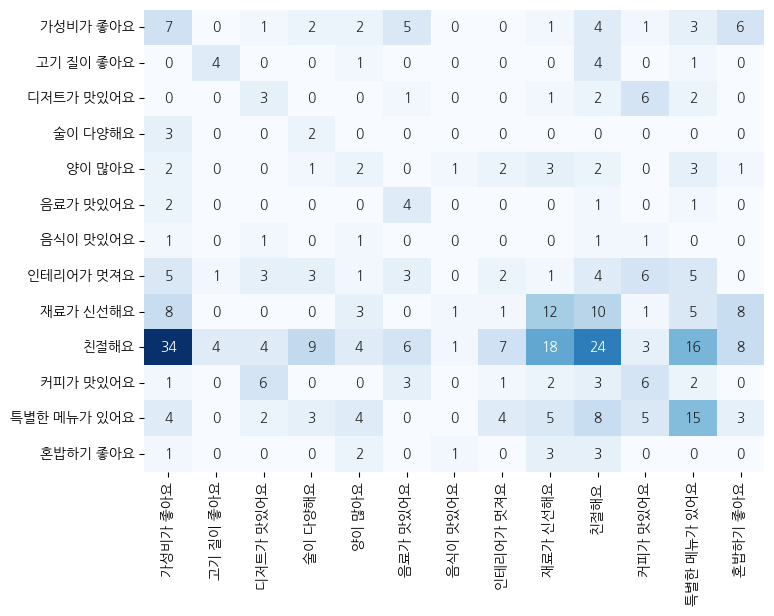

In [ ]:
# 불러온 모델로 예측
final_preds = dt.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(dt, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 인테리어가 멋져요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(dt, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 양이 많아요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(dt, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 특별한 메뉴가 있어요


## XGBClassifier

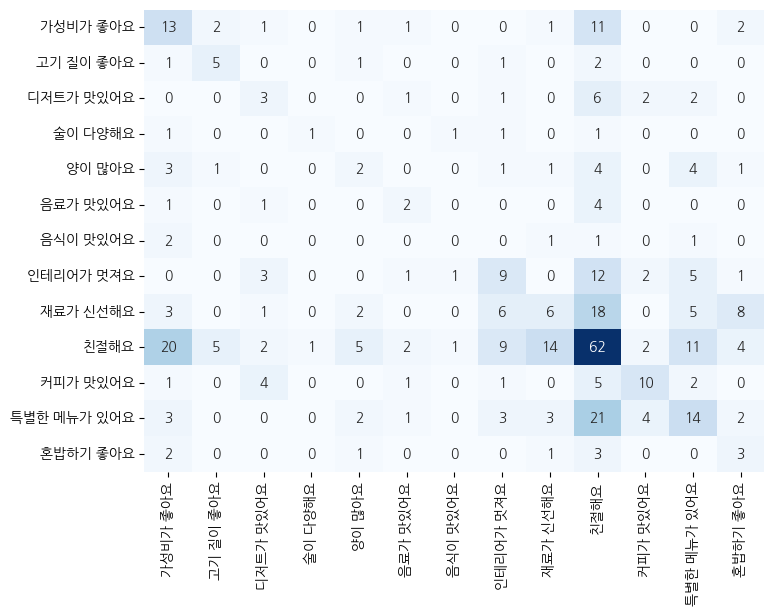

In [ ]:
# 불러온 모델로 예측
final_preds = xgbc.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(xgbc, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(xgbc, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 친절해요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(xgbc, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


## LGBMClassifier

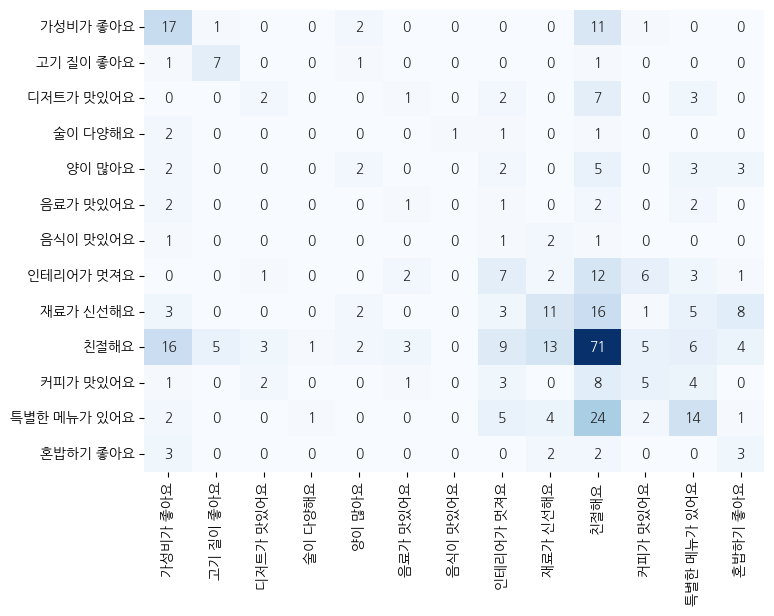

In [ ]:
# 불러온 모델로 예측
final_preds = lgbc.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(lgbc, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(lgbc, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 가성비가 좋아요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(lgbc, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


## SVM

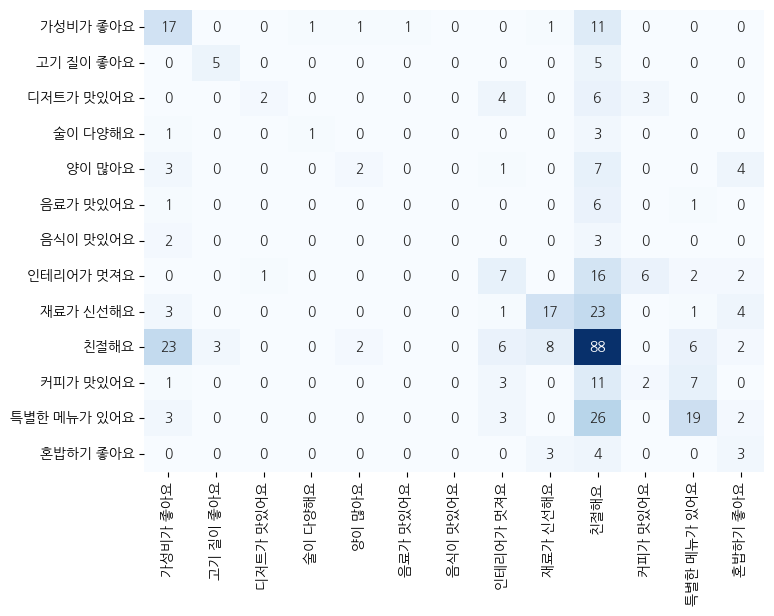

In [ ]:
# 불러온 모델로 예측
final_preds = svm.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(svm, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(svm, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 가성비가 좋아요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(svm, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


## Random Forest

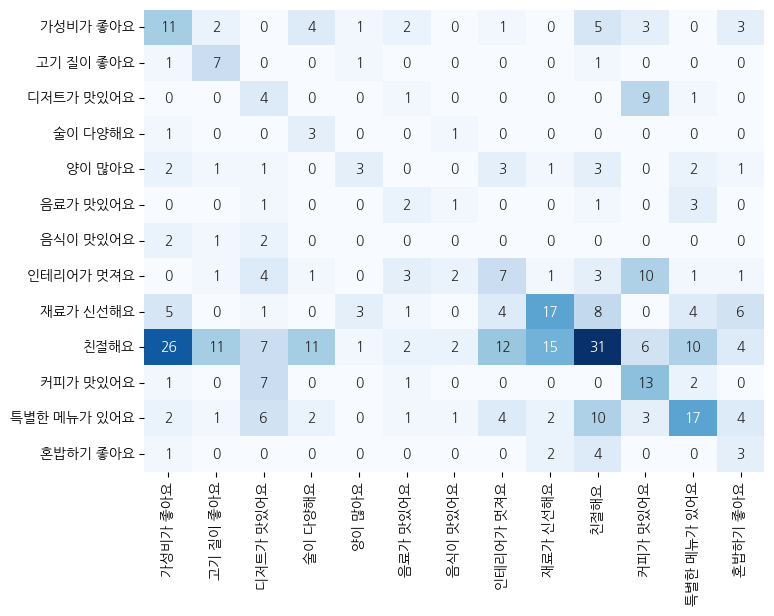

In [ ]:
# 불러온 모델로 예측
final_preds = rf.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(rf, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(rf, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 가성비가 좋아요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(rf, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


## Catboost

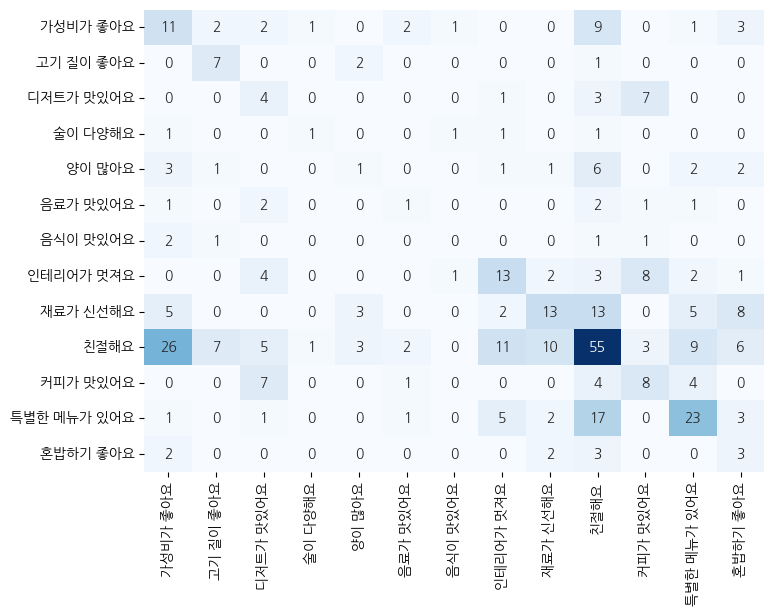

In [ ]:
# 불러온 모델로 예측
final_preds = cb.predict(X_test)

#confusion matrix
col = le.classes_
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_ml(cb, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 음식이 맛있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 음식이 맛있어요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 음식이 맛있어요


In [ ]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(cb, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 계속 근처를 오갔었는데, 졸업하고서야 얼마 전에서야 알게 된 아콘스톨! 미리 알았다면 학교 다닐 때부터 엄청난 단골이 되었을 것 같아요ㅎㅎ 뭐 일단 앞으로 단골이 될 테지만요!! 사장님이 착한가격 가게로 선정되었다 자랑하시는 모습이 너무 귀여우셨어요ㅠㅠ 사장님의 친절함과 따뜻한 음식으로 배도 마음도 든든해지는 곳입니다♡ 오징어 김밥은 라면이랑 같이 먹으면 더 맛있을 것 같지만, 며칠 계속 매운 걸 먹어서 단독으로 슴슴하면서도 담백하게 먹기 좋았어요~ 건강히 오래 장사해주세요 :)
예측된 키워드: 가성비가 좋아요


In [ ]:
#아민 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_ml(cb, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


## LSTM

In [84]:
# LSTM 모델 평가 모드로 전환
lstm.eval()

# LSTM 모델의 예측 확률 및 예측값 가져오기
with torch.no_grad():
    # LSTM 입력을 위해 3차원으로 변환 (batch_size, sequence_length, num_features)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).unsqueeze(1).to(device)  # unsqueeze로 차원 추가
    lstm_outputs = lstm(X_test_tensor)  # LSTM 모델의 raw logits 출력
    lstm_probs = F.softmax(lstm_outputs, dim=1).cpu().numpy()  # 소프트맥스 함수 적용 후 확률로 변환
    lstm_preds = np.argmax(lstm_probs, axis=1)  # 가장 높은 확률을 가진 클래스 선택

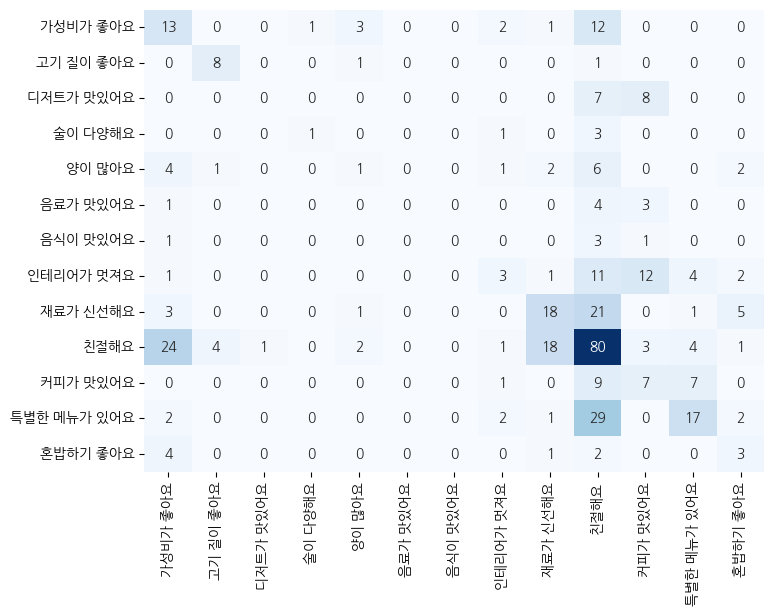

In [35]:
# confusion matrix 생성
cm = confusion_matrix(y_test, lstm_preds)

# confusion matrix 시각화
col = le.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=col, yticklabels=col)
plt.show()

리뷰 텍스트 예측

In [ ]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_dl(lstm, review_input, tfidf_okt, okt, device, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [85]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_dl(lstm, review_input, tfidf_okt, okt, device, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 소문으로만 들어 보다 오늘 처음 갔어요! 음식도 너무 맛있고 사장님도 정말 친절하세요ㅠㅠ 가성비도 좋아서 간단히 한끼 먹고 싶을 때 자주갈 것 같아요!! 앞으로도 번창하세요 :)
예측된 키워드: 가성비가 좋아요


In [86]:
#아건 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_dl(lstm, review_input, tfidf_okt, okt, device, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


# 모델 전체 사용 Voting

In [37]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
for model in [dt, xgbc, lgbc, svm, rf, cb]:
  pred = model.predict(X_test)
  print(pred.shape)

(400,)
(400,)
(400,)
(400,)
(400,)
(400, 1)


In [39]:
# 머신러닝 모델들의 예측값 (하드 보팅용)
# cb만 형태 달라서 따로 빼서 고치기
ml_preds = np.array([
    model.predict(X_test).ravel() if model != cb else model.predict(X_test).reshape(-1,)
    for model in [dt, xgbc, lgbc, svm, rf, cb]
])

# 머신러닝 모델들의 예측 확률 (소프트 보팅용)
ml_probs = np.array([model.predict_proba(X_test) for model in [dt, xgbc, lgbc, svm, rf, cb]])
ml_probs_list = [model.predict_proba(X_test) for model in [dt, xgbc, lgbc, svm, rf, cb]]

In [40]:
# LSTM 모델 평가 모드로 전환
lstm.eval()

# LSTM 모델의 예측 확률 및 예측값 가져오기
with torch.no_grad():
    # LSTM 입력을 위해 3차원으로 변환 (batch_size, sequence_length, num_features)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).unsqueeze(1).to(device)  # unsqueeze로 차원 추가
    lstm_outputs = lstm(X_test_tensor)  # LSTM 모델의 raw logits 출력
    lstm_probs = F.softmax(lstm_outputs, dim=1).cpu().numpy()  # 소프트맥스 함수 적용 후 확률로 변환
    lstm_preds = np.argmax(lstm_probs, axis=1)  # 가장 높은 확률을 가진 클래스 선택

## 하드 보팅

In [41]:
def hard_voting(ml_preds, dl_preds, weights):
    all_preds = np.vstack((ml_preds, dl_preds))
    weighted_preds = np.apply_along_axis(lambda x: np.bincount(x, weights=weights).argmax(), axis=0, arr=all_preds)
    return weighted_preds

In [42]:
# 하드 보팅 Optuna
def objective(trial):
    weights = [
        trial.suggest_float('ml1_weight', 0.0, 10.0),
        trial.suggest_float('ml2_weight', 0.0, 10.0),
        trial.suggest_float('ml3_weight', 0.0, 10.0),
        trial.suggest_float('ml4_weight', 0.0, 10.0),
        trial.suggest_float('ml5_weight', 0.0, 10.0),
        trial.suggest_float('ml6_weight', 0.0, 10.0),
        trial.suggest_float('dl_weight', 0.0, 10.0)
    ]
    # 하드 보팅 예측 결과
    final_hard_preds = hard_voting(ml_preds, lstm_preds, weights)
    hard_accuracy = accuracy_score(y_test, final_hard_preds)

    return hard_accuracy

# Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 가중치 출력
hard_best_weights = study.best_params
print(f'Best weights: {hard_best_weights}')

[I 2024-08-18 09:22:56,816] A new study created in memory with name: no-name-65a41712-a5bc-45f0-9f3b-205002a0e643
[I 2024-08-18 09:22:56,832] Trial 0 finished with value: 0.3475 and parameters: {'ml1_weight': 8.545887577771737, 'ml2_weight': 6.274854682373679, 'ml3_weight': 9.471367504608828, 'ml4_weight': 0.17479456320289022, 'ml5_weight': 0.8607398994482585, 'ml6_weight': 8.898624171677998, 'dl_weight': 7.484677593206332}. Best is trial 0 with value: 0.3475.
[I 2024-08-18 09:22:56,839] Trial 1 finished with value: 0.37 and parameters: {'ml1_weight': 5.4456559332405625, 'ml2_weight': 9.554148468139458, 'ml3_weight': 3.7755724330135063, 'ml4_weight': 8.039307588744586, 'ml5_weight': 8.470123789499858, 'ml6_weight': 7.567545838054494, 'dl_weight': 6.398710626637387}. Best is trial 1 with value: 0.37.
[I 2024-08-18 09:22:56,845] Trial 2 finished with value: 0.33 and parameters: {'ml1_weight': 8.980216363155263, 'ml2_weight': 4.931092683808683, 'ml3_weight': 8.001883596288156, 'ml4_weight

Best weights: {'ml1_weight': 1.6437976064359079, 'ml2_weight': 0.6809213428937244, 'ml3_weight': 3.9110409233456718, 'ml4_weight': 8.47514394311765, 'ml5_weight': 0.8335596885794352, 'ml6_weight': 6.76411105234475, 'dl_weight': 6.377384540640282}


### 결과 시각화

In [43]:
# 최적 가중치 배열
hard_optimal_weights = [hard_best_weights[f'ml{i+1}_weight'] for i in range(6)] + [hard_best_weights['dl_weight']]

# 하드 보팅 결과
final_hard_preds = hard_voting(ml_preds, lstm_preds, hard_optimal_weights)
hard_accuracy = accuracy_score(y_test, final_hard_preds)
print(f'Hard Voting Accuracy: {hard_accuracy:.4f}')

Hard Voting Accuracy: 0.4325


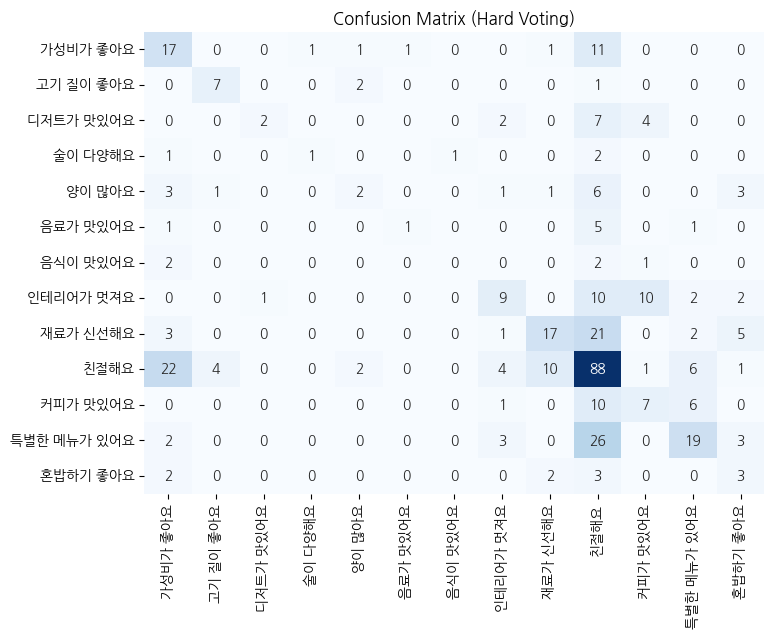

In [44]:
# Confusion Matrix for Hard Voting
cm_hard = confusion_matrix(y_test, final_hard_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hard, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Hard Voting)')
plt.show()

### 리뷰 예측 함수

In [45]:
#ML 리뷰 예측 함수 hard voting
def predict_review_hard_voting(ml_models, optimal_weights, review, tfidf_vectorizer, label_encoder):
  # 입력된 리뷰를 TF-IDF로 변환
  review_tfidf = tfidf_vectorizer.transform([review])
  ml_preds = np.array([model.predict(review_tfidf).ravel() if model != cb else model.predict(review_tfidf).reshape(-1,) for model in ml_models])
  ml_probs_list = [model.predict_proba(review_tfidf) for model in ml_models]
  # LSTM 모델 평가 모드로 전환
  lstm.eval()

  # LSTM 모델의 예측 확률 및 예측값 가져오기
  with torch.no_grad():
      # LSTM 입력을 위해 3차원으로 변환 (batch_size, sequence_length, num_features)
      review_tensor = torch.tensor(review_tfidf.toarray(), dtype=torch.float32).unsqueeze(1).to(device)  # unsqueeze로 차원 추가
      lstm_outputs = lstm(review_tensor)  # LSTM 모델의 raw logits 출력
      lstm_probs = F.softmax(lstm_outputs, dim=1).cpu().numpy()  # 소프트맥스 함수 적용 후 확률로 변환
      lstm_preds = np.argmax(lstm_probs, axis=1)  # 가장 높은 확률을 가진 클래스 선택
  final_hard_preds = hard_voting(ml_preds, lstm_preds, optimal_weights)

  # 인코딩된 라벨을 원래의 라벨로 디코딩
  decoded_label = label_encoder.inverse_transform([final_hard_preds.item()])[0]

  return decoded_label

In [46]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_hard_voting([dt, xgbc, lgbc, svm, rf, cb], hard_optimal_weights, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [52]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([dt, xgbc, lgbc, svm, rf, cb], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 소문으로만 들어 보다 오늘 처음 갔어요! 음식도 너무 맛있고 사장님도 정말 친절하세요ㅠㅠ 가성비도 좋아서 간단히 한끼 먹고 싶을 때 자주갈 것 같아요!! 앞으로도 번창하세요 :)
예측된 키워드: 가성비가 좋아요


In [48]:
#아건 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([dt, xgbc, lgbc, svm, rf, cb], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


In [50]:
#사장님돈까스 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([dt, xgbc, lgbc, svm, rf, cb], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이대 앞 돈까스 최고 맛집!! 사장님돈까스 먹고왔어요!!! 짱짱 맛있었고 양도 진짜 많이 주셔서 배부르게 맛나게먹었습니다 특히 초계비빔냉면 요즘 같은 날씨 진짜 딱이고 시원하고 달달구리 새콤양념 굿 👍🏻 비냄에 돈까스 올려서 먹으니 꿀맛 그자체입니다!! 그리고 스프도 나오고 모닝빵도 나와서 이것저것 먹을 수 있어서 더욱 맛나게 먹고왔습니다 그리곡!!! 고구마치즈돈까스!! 치즈를 짱 많이 넣어주셔서 치즈먹는 식감 넘 좋고 고소하니 맛있었네요👍🏻👍🏻 돈까스는 물론 바삭바삭 맛있었어요
예측된 키워드: 양이 많아요


In [51]:
#슬로우캘리 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([dt, xgbc, lgbc, svm, rf, cb], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 인기 진짜많아요.... 10000원 초반대의 가격으로 참치, 연어 위주의 포케를 먹을 수 있는 곳입니다!! 여기 굉장히 많이 왔어서 이것저것 다 먹어봤는데 스파이시 참치 포케 존맛이에용💚 평일은피크시간대 사람이 굉장히 붐빕니다ㅠㅜ 그만큼 재료의 회전이 빠르고 신선도가 좋은 편이고용. 개인적으로 매운 음식을 좋아하는데 여긴 매콤한 포케를 즐길 수 있어서 좋아하는 편입니다.
예측된 키워드: 재료가 신선해요


## 소프트 보팅

In [53]:
def soft_voting(ml_probs_list, dl_probs, weights):
    # 모든 모델의 예측 확률을 (400, 13) 형태로 결합
    all_probs = np.stack(ml_probs_list + [dl_probs], axis=0)  # Shape: (7, 400, 13)

    # 각 모델에 대해 가중치를 적용하여 예측 확률을 가중 평균
    weighted_probs = np.average(all_probs, axis=0, weights=weights)  # Shape: (400, 13)

    # 최종 예측값 계산
    return np.argmax(weighted_probs, axis=1)  # Shape: (400,)

In [54]:
#소프트 보팅 Optuna
def objective(trial):
    weights = [
        trial.suggest_float('ml1_weight', 0.0, 10.0),
        trial.suggest_float('ml2_weight', 0.0, 10.0),
        trial.suggest_float('ml3_weight', 0.0, 10.0),
        trial.suggest_float('ml4_weight', 0.0, 10.0),
        trial.suggest_float('ml5_weight', 0.0, 10.0),
        trial.suggest_float('ml6_weight', 0.0, 10.0),
        trial.suggest_float('dl_weight', 0.0, 10.0)
    ]
    # 소프트 보팅 예측 결과
    final_soft_preds = soft_voting(ml_probs_list, lstm_probs, weights)
    soft_accuracy = accuracy_score(y_test, final_soft_preds)

    return soft_accuracy

# Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 가중치 출력
soft_best_weights = study.best_params
print(f'Best weights: {soft_best_weights}')

[I 2024-08-18 09:35:51,583] A new study created in memory with name: no-name-60da7108-1dfc-43f5-8e9e-dd11a4e34211
[I 2024-08-18 09:35:51,591] Trial 0 finished with value: 0.3475 and parameters: {'ml1_weight': 8.670680938478652, 'ml2_weight': 0.17954304603540194, 'ml3_weight': 2.7263430901941668, 'ml4_weight': 9.098791158130222, 'ml5_weight': 4.36151110606936, 'ml6_weight': 8.046164808907436, 'dl_weight': 5.765127171637237}. Best is trial 0 with value: 0.3475.
[I 2024-08-18 09:35:51,596] Trial 1 finished with value: 0.365 and parameters: {'ml1_weight': 7.439397552918812, 'ml2_weight': 9.954550871689134, 'ml3_weight': 9.222364802762376, 'ml4_weight': 6.477763478202199, 'ml5_weight': 3.5519133189199903, 'ml6_weight': 7.165602075496454, 'dl_weight': 5.955709363897885}. Best is trial 1 with value: 0.365.
[I 2024-08-18 09:35:51,601] Trial 2 finished with value: 0.365 and parameters: {'ml1_weight': 6.300639445316069, 'ml2_weight': 2.347829861915236, 'ml3_weight': 7.203000262116024, 'ml4_weigh

Best weights: {'ml1_weight': 0.1864015832973674, 'ml2_weight': 2.752444727220697, 'ml3_weight': 4.503789952884119, 'ml4_weight': 8.619009192227667, 'ml5_weight': 1.3455104741642745, 'ml6_weight': 3.951801982778507, 'dl_weight': 3.2020100829024813}


### 결과 시각화

In [55]:
# 최적 가중치 배열
soft_optimal_weights = [soft_best_weights[f'ml{i+1}_weight'] for i in range(6)] + [soft_best_weights['dl_weight']]

# 소프트 보팅 결과
final_soft_preds = soft_voting(ml_probs_list, lstm_probs, soft_optimal_weights)
soft_accuracy = accuracy_score(y_test, final_soft_preds)
print(f'Soft Voting Accuracy: {soft_accuracy:.4f}')

Soft Voting Accuracy: 0.4300


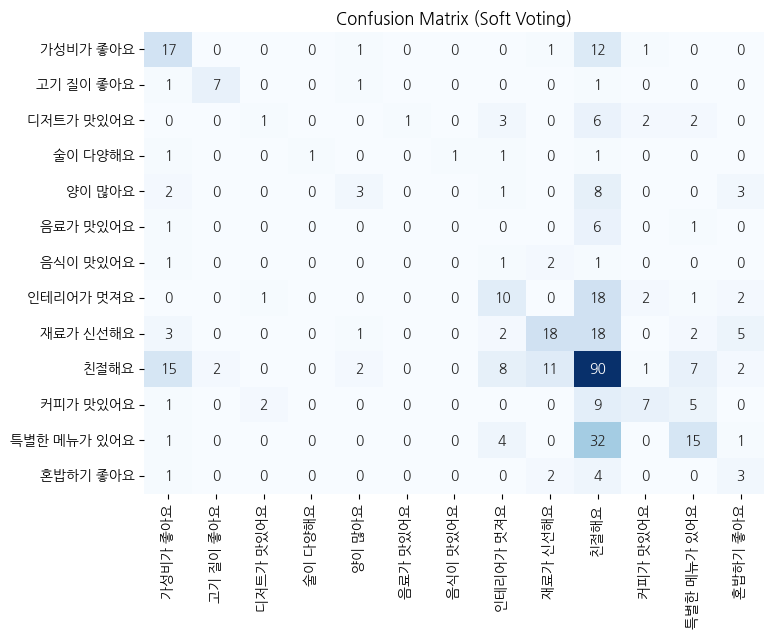

In [56]:
# Confusion Matrix for Soft Voting
cm_soft = confusion_matrix(y_test, final_soft_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Soft Voting)')
plt.show()

### 리뷰 예측 함수

In [57]:
#ML 리뷰 예측 함수 soft voting
def predict_review_soft_voting(ml_models, optimal_weights, review, tfidf_vectorizer, label_encoder):
  # 입력된 리뷰를 TF-IDF로 변환
  review_tfidf = tfidf_vectorizer.transform([review])
  ml_probs_list = [model.predict_proba(review_tfidf) for model in ml_models]
  # LSTM 모델 평가 모드로 전환
  lstm.eval()

  # LSTM 모델의 예측 확률 및 예측값 가져오기
  with torch.no_grad():
      # LSTM 입력을 위해 3차원으로 변환 (batch_size, sequence_length, num_features)
      review_tensor = torch.tensor(review_tfidf.toarray(), dtype=torch.float32).unsqueeze(1).to(device)  # unsqueeze로 차원 추가
      lstm_outputs = lstm(review_tensor)  # LSTM 모델의 raw logits 출력
      lstm_probs = F.softmax(lstm_outputs, dim=1).cpu().numpy()  # 소프트맥스 함수 적용 후 확률로 변환
      lstm_preds = np.argmax(lstm_probs, axis=1)  # 가장 높은 확률을 가진 클래스 선택
  final_soft_preds = soft_voting(ml_probs_list, lstm_probs, optimal_weights)

  # 인코딩된 라벨을 원래의 라벨로 디코딩
  decoded_label = label_encoder.inverse_transform([final_soft_preds.item()])[0]

  return decoded_label

리뷰 텍스트 예측

In [58]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_soft_voting([dt, xgbc, lgbc, svm, rf, cb], soft_optimal_weights, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [59]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([dt, xgbc, lgbc, svm, rf, cb], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 소문으로만 들어 보다 오늘 처음 갔어요! 음식도 너무 맛있고 사장님도 정말 친절하세요ㅠㅠ 가성비도 좋아서 간단히 한끼 먹고 싶을 때 자주갈 것 같아요!! 앞으로도 번창하세요 :)
예측된 키워드: 가성비가 좋아요


In [60]:
#아건 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([dt, xgbc, lgbc, svm, rf, cb], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


In [63]:
#사장님돈까스 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([dt, xgbc, lgbc, svm, rf, cb], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이대 앞 돈까스 최고 맛집!! 사장님돈까스 먹고왔어요!!! 짱짱 맛있었고 양도 진짜 많이 주셔서 배부르게 맛나게먹었습니다 특히 초계비빔냉면 요즘 같은 날씨 진짜 딱이고 시원하고 달달구리 새콤양념 굿 👍🏻 비냄에 돈까스 올려서 먹으니 꿀맛 그자체입니다!! 그리고 스프도 나오고 모닝빵도 나와서 이것저것 먹을 수 있어서 더욱 맛나게 먹고왔습니다 그리곡!!! 고구마치즈돈까스!! 치즈를 짱 많이 넣어주셔서 치즈먹는 식감 넘 좋고 고소하니 맛있었네요👍🏻👍🏻 돈까스는 물론 바삭바삭 맛있었어요
예측된 키워드: 가성비가 좋아요


In [64]:
#슬로우캘리 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([dt, xgbc, lgbc, svm, rf, cb], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 인기 진짜많아요.... 10000원 초반대의 가격으로 참치, 연어 위주의 포케를 먹을 수 있는 곳입니다!! 여기 굉장히 많이 왔어서 이것저것 다 먹어봤는데 스파이시 참치 포케 존맛이에용💚 평일은피크시간대 사람이 굉장히 붐빕니다ㅠㅜ 그만큼 재료의 회전이 빠르고 신선도가 좋은 편이고용. 개인적으로 매운 음식을 좋아하는데 여긴 매콤한 포케를 즐길 수 있어서 좋아하는 편입니다.
예측된 키워드: 재료가 신선해요


# LSTM + SVM

In [65]:
# 머신러닝 모델들의 예측값 (하드 보팅용)
ml_preds = np.array([svm.predict(X_test)])

# 머신러닝 모델들의 예측 확률 (소프트 보팅용)
ml_probs = np.array([svm.predict_proba(X_test)])
ml_probs_list = [svm.predict_proba(X_test)]

In [66]:
# LSTM 모델 평가 모드로 전환
lstm.eval()

# LSTM 모델의 예측 확률 및 예측값 가져오기
with torch.no_grad():
    # LSTM 입력을 위해 3차원으로 변환 (batch_size, sequence_length, num_features)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).unsqueeze(1).to(device)  # unsqueeze로 차원 추가
    lstm_outputs = lstm(X_test_tensor)  # LSTM 모델의 raw logits 출력
    lstm_probs = F.softmax(lstm_outputs, dim=1).cpu().numpy()  # 소프트맥스 함수 적용 후 확률로 변환
    lstm_preds = np.argmax(lstm_probs, axis=1)  # 가장 높은 확률을 가진 클래스 선택

## 하드 보팅

In [67]:
# 하드 보팅 Optuna
def objective(trial):
    weights = [
        trial.suggest_float('ml1_weight', 0.0, 10.0),
        trial.suggest_float('dl_weight', 0.0, 10.0)
    ]
    # 하드 보팅 예측 결과
    final_hard_preds = hard_voting(ml_preds, lstm_preds, weights)
    hard_accuracy = accuracy_score(y_test, final_hard_preds)

    return hard_accuracy

# Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 가중치 출력
hard_best_weights = study.best_params
print(f'Best weights: {hard_best_weights}')

[I 2024-08-18 09:42:55,043] A new study created in memory with name: no-name-14e3b9ef-8625-4e93-ac08-91b6b7e274b1
[I 2024-08-18 09:42:55,049] Trial 0 finished with value: 0.4075 and parameters: {'ml1_weight': 8.61140539178902, 'dl_weight': 4.825557847462005}. Best is trial 0 with value: 0.4075.
[I 2024-08-18 09:42:55,053] Trial 1 finished with value: 0.4075 and parameters: {'ml1_weight': 6.703038182080986, 'dl_weight': 5.530574731453603}. Best is trial 0 with value: 0.4075.
[I 2024-08-18 09:42:55,058] Trial 2 finished with value: 0.3775 and parameters: {'ml1_weight': 8.743103263200373, 'dl_weight': 9.608017753990401}. Best is trial 0 with value: 0.4075.
[I 2024-08-18 09:42:55,062] Trial 3 finished with value: 0.3775 and parameters: {'ml1_weight': 2.849200640538169, 'dl_weight': 5.856042047847819}. Best is trial 0 with value: 0.4075.
[I 2024-08-18 09:42:55,067] Trial 4 finished with value: 0.4075 and parameters: {'ml1_weight': 9.662592308303813, 'dl_weight': 1.8462469286288274}. Best is

Best weights: {'ml1_weight': 8.61140539178902, 'dl_weight': 4.825557847462005}


### 결과 시각화

In [68]:
# 최적 가중치 배열
hard_optimal_weights = [hard_best_weights['ml1_weight']] + [hard_best_weights['dl_weight']]

# 하드 보팅 결과
final_hard_preds = hard_voting(ml_preds, lstm_preds, hard_optimal_weights)
hard_accuracy = accuracy_score(y_test, final_hard_preds)
print(f'Hard Voting Accuracy: {hard_accuracy:.4f}')

Hard Voting Accuracy: 0.4075


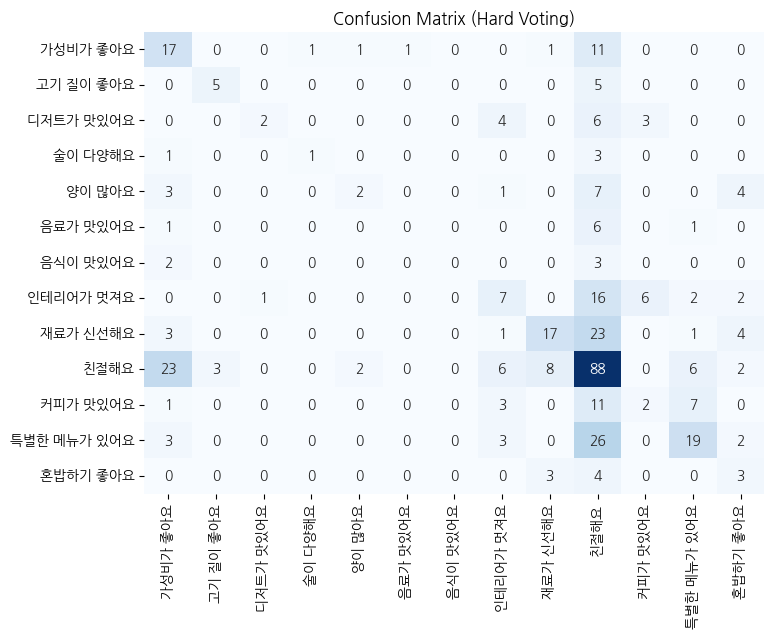

In [69]:
# Confusion Matrix for Hard Voting
cm_hard = confusion_matrix(y_test, final_hard_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hard, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Hard Voting)')
plt.show()

### 리뷰 예측 함수

In [70]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_hard_voting([svm], hard_optimal_weights, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [71]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([svm], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 소문으로만 들어 보다 오늘 처음 갔어요! 음식도 너무 맛있고 사장님도 정말 친절하세요ㅠㅠ 가성비도 좋아서 간단히 한끼 먹고 싶을 때 자주갈 것 같아요!! 앞으로도 번창하세요 :)
예측된 키워드: 가성비가 좋아요


In [73]:
#아건 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([svm], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


In [74]:
#사장님돈까스 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([svm], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이대 앞 돈까스 최고 맛집!! 사장님돈까스 먹고왔어요!!! 짱짱 맛있었고 양도 진짜 많이 주셔서 배부르게 맛나게먹었습니다 특히 초계비빔냉면 요즘 같은 날씨 진짜 딱이고 시원하고 달달구리 새콤양념 굿 👍🏻 비냄에 돈까스 올려서 먹으니 꿀맛 그자체입니다!! 그리고 스프도 나오고 모닝빵도 나와서 이것저것 먹을 수 있어서 더욱 맛나게 먹고왔습니다 그리곡!!! 고구마치즈돈까스!! 치즈를 짱 많이 넣어주셔서 치즈먹는 식감 넘 좋고 고소하니 맛있었네요👍🏻👍🏻 돈까스는 물론 바삭바삭 맛있었어요
예측된 키워드: 양이 많아요


In [75]:
#슬로우캘리 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_hard_voting([svm], hard_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 인기 진짜많아요.... 10000원 초반대의 가격으로 참치, 연어 위주의 포케를 먹을 수 있는 곳입니다!! 여기 굉장히 많이 왔어서 이것저것 다 먹어봤는데 스파이시 참치 포케 존맛이에용💚 평일은피크시간대 사람이 굉장히 붐빕니다ㅠㅜ 그만큼 재료의 회전이 빠르고 신선도가 좋은 편이고용. 개인적으로 매운 음식을 좋아하는데 여긴 매콤한 포케를 즐길 수 있어서 좋아하는 편입니다.
예측된 키워드: 재료가 신선해요


## 소프트 보팅

In [76]:
#소프트 보팅 Optuna
def objective(trial):
    weights = [
        trial.suggest_float('ml1_weight', 0.0, 10.0),
        trial.suggest_float('dl_weight', 0.0, 10.0)
    ]
    # 소프트 보팅 예측 결과
    final_soft_preds = soft_voting(ml_probs_list, lstm_probs, weights)
    soft_accuracy = accuracy_score(y_test, final_soft_preds)

    return soft_accuracy

# Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 가중치 출력
soft_best_weights = study.best_params
print(f'Best weights: {soft_best_weights}')

[I 2024-08-18 09:46:36,042] A new study created in memory with name: no-name-29516483-e9b4-46da-99b8-f66cc3bc9c7f
[I 2024-08-18 09:46:36,047] Trial 0 finished with value: 0.375 and parameters: {'ml1_weight': 0.09844913567389257, 'dl_weight': 7.929616519392902}. Best is trial 0 with value: 0.375.
[I 2024-08-18 09:46:36,051] Trial 1 finished with value: 0.4125 and parameters: {'ml1_weight': 8.100140805464664, 'dl_weight': 2.42621663014274}. Best is trial 1 with value: 0.4125.
[I 2024-08-18 09:46:36,053] Trial 2 finished with value: 0.3975 and parameters: {'ml1_weight': 4.659442897823963, 'dl_weight': 6.5599066657888985}. Best is trial 1 with value: 0.4125.
[I 2024-08-18 09:46:36,056] Trial 3 finished with value: 0.39 and parameters: {'ml1_weight': 5.737001124619968, 'dl_weight': 9.933368294235775}. Best is trial 1 with value: 0.4125.
[I 2024-08-18 09:46:36,059] Trial 4 finished with value: 0.41 and parameters: {'ml1_weight': 6.692694330737194, 'dl_weight': 2.3212678104454287}. Best is tr

Best weights: {'ml1_weight': 9.210182151579598, 'dl_weight': 1.9139530114853343}


### 결과 시각화

In [77]:
# 최적 가중치 배열
soft_optimal_weights = [soft_best_weights['ml1_weight']] + [soft_best_weights['dl_weight']]

# 소프트 보팅 결과
final_soft_preds = soft_voting(ml_probs_list, lstm_probs, soft_optimal_weights)
soft_accuracy = accuracy_score(y_test, final_soft_preds)
print(f'Soft Voting Accuracy: {soft_accuracy:.4f}')

Soft Voting Accuracy: 0.4175


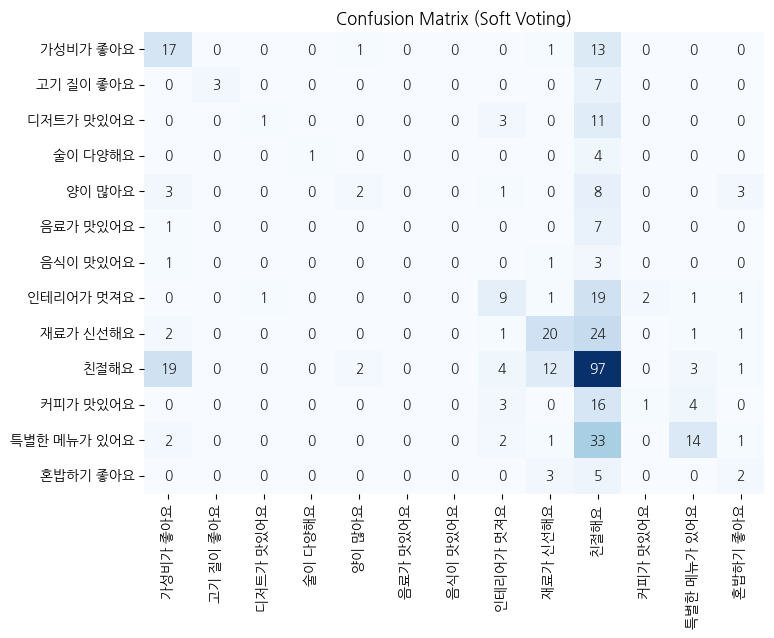

In [78]:
# Confusion Matrix for Soft Voting
cm_soft = confusion_matrix(y_test, final_soft_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Soft Voting)')
plt.show()

### 리뷰 예측 함수

리뷰 텍스트 예측

In [79]:
for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review_soft_voting([svm], soft_optimal_weights, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [80]:
#아콘스톨 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([svm], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 소문으로만 들어 보다 오늘 처음 갔어요! 음식도 너무 맛있고 사장님도 정말 친절하세요ㅠㅠ 가성비도 좋아서 간단히 한끼 먹고 싶을 때 자주갈 것 같아요!! 앞으로도 번창하세요 :)
예측된 키워드: 가성비가 좋아요


In [81]:
#아건 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([svm], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 정통 인도요리전문점 이대맛집 아건 너무 좋네요 사장님 친절하시구요 음식 다 맛있어요 난도 여러 종류 다 맛나구요 커리도 호불호 갈리기 않고 맛있어요 샐러드랑 라씨도 맛나구요 사장님이 디테일을 굉장히 신경쓰셔서 음식이 다 맘있는것같아요~^^ 인도 요리 좋아하시는분들 꼭 방문해보세요 ^^
예측된 키워드: 친절해요


In [82]:
#사장님돈까스 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([svm], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이대 앞 돈까스 최고 맛집!! 사장님돈까스 먹고왔어요!!! 짱짱 맛있었고 양도 진짜 많이 주셔서 배부르게 맛나게먹었습니다 특히 초계비빔냉면 요즘 같은 날씨 진짜 딱이고 시원하고 달달구리 새콤양념 굿 👍🏻 비냄에 돈까스 올려서 먹으니 꿀맛 그자체입니다!! 그리고 스프도 나오고 모닝빵도 나와서 이것저것 먹을 수 있어서 더욱 맛나게 먹고왔습니다 그리곡!!! 고구마치즈돈까스!! 치즈를 짱 많이 넣어주셔서 치즈먹는 식감 넘 좋고 고소하니 맛있었네요👍🏻👍🏻 돈까스는 물론 바삭바삭 맛있었어요
예측된 키워드: 양이 많아요


In [83]:
#슬로우캘리 리뷰 테스트
review_input = input("리뷰를 입력하세요: ")

predicted_label = predict_review_soft_voting([svm], soft_optimal_weights, review_input, tfidf_okt, le)
print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 인기 진짜많아요.... 10000원 초반대의 가격으로 참치, 연어 위주의 포케를 먹을 수 있는 곳입니다!! 여기 굉장히 많이 왔어서 이것저것 다 먹어봤는데 스파이시 참치 포케 존맛이에용💚 평일은피크시간대 사람이 굉장히 붐빕니다ㅠㅜ 그만큼 재료의 회전이 빠르고 신선도가 좋은 편이고용. 개인적으로 매운 음식을 좋아하는데 여긴 매콤한 포케를 즐길 수 있어서 좋아하는 편입니다.
예측된 키워드: 재료가 신선해요
